In [3]:
from scipy.special import erf
import matplotlib.pyplot as plt
import numpy as np

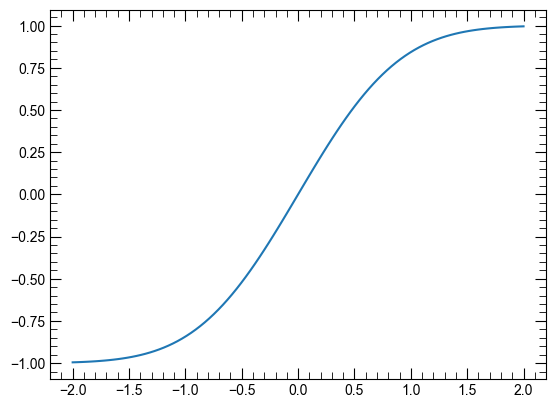

In [4]:
erf(1)
x = np.linspace(-2, 2, 100)
y = erf(x)
plt.plot(x, y)
plt.show()